Processing Game IDs: 100%|██████████| 951/951 [20:22<00:00,  1.29s/it]


     Bin Range Percentage    Count
0  0.00 - 0.10      99.0%  2180885
1  0.10 - 0.20       0.0%       45
2  0.20 - 0.30       0.0%       18
3  0.30 - 0.40       0.0%       17
4  0.40 - 0.50       0.0%       12
5  0.50 - 0.60       0.0%        7
6  0.60 - 0.70       0.0%        3
7  0.70 - 0.80       0.0%        2
8  0.80 - 0.90       0.0%        2
9  0.90 - 1.00       0.0%        1


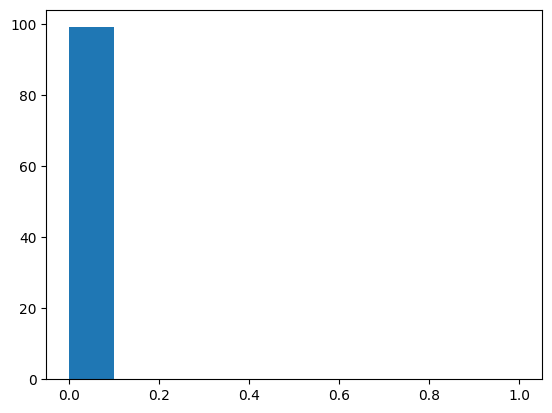

In [9]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
df = pd.read_parquet('processed_data/women_imbalanced_node_features.parquet')
# Define the ball criteria
ball_criteria = (df['dist_ball'] == 0) & (df['angle_ball'] == 0)
df['player_num_label'] = None

# Remap game_id to have no gaps
unique_game_ids = df['game_id'].unique()
game_id_mapping = {old_id: new_id for new_id, old_id in enumerate(sorted(unique_game_ids))}
df['game_id'] = df['game_id'].map(game_id_mapping)

# Impute label 0 for the ball
df.loc[ball_criteria, 'player_num_label'] = 0

# Iterate over each game_id with a progress bar
for game_id in tqdm(df['game_id'].unique(), desc="Processing Game IDs"):
    # Select the first frame (frame_id = 0) for the current game_id
    first_frame = df[(df['game_id'] == game_id) & (df['frame_id'] == 0) & (~ball_criteria)].copy()
    
    # Label the first 22 non-ball players
    first_frame['player_num_label'] = np.arange(1, 23)
    
    # Update the main dataframe with these labels
    df.update(first_frame[['player_num_label']])
    
    # Set prev_frame_data for tracking players across frames
    prev_frame_data = first_frame

    # Iterate through subsequent frames for the current game_id with a progress bar
    frame_ids = sorted(df[df['game_id'] == game_id]['frame_id'].unique())
    for frame_id in tqdm(frame_ids, desc=f"Processing Frames for Game ID {game_id}", leave=False):
        if frame_id == 0:
            continue
        
        # Get current frame data excluding the ball
        current_frame_data = df[(df['game_id'] == game_id) & (df['frame_id'] == frame_id) & (~ball_criteria)].copy()

        if current_frame_data.empty:
            continue

        # Compute Euclidean distance from each player in the current frame to each player in the previous frame
        distance_matrix = np.sqrt(
            (current_frame_data['x'].values[:, np.newaxis] - prev_frame_data['x'].values) ** 2 +
            (current_frame_data['y'].values[:, np.newaxis] - prev_frame_data['y'].values) ** 2
        )

        labeled_indices = []
        # Iterate through each player in the previous frame
        for i, prev_row in prev_frame_data.iterrows():
            if len(current_frame_data) == 0:
                break

            # Filter the current frame data to only include rows with the same att_team value
            team_filtered_data = current_frame_data[current_frame_data['att_team'] == prev_row['att_team']]

            if team_filtered_data.empty:
                continue

            # Calculate the Euclidean distance to the filtered current frame data
            distances = np.sqrt(
                (team_filtered_data['x'].values - prev_row['x']) ** 2 +
                (team_filtered_data['y'].values - prev_row['y']) ** 2
            )

            # Find the closest point in the filtered current frame
            if len(distances) == 0:
                continue

            closest_idx = np.argmin(distances)
            
            # Ensure the index is valid
            if closest_idx >= len(team_filtered_data):
                continue

            closest_point_idx = team_filtered_data.index[closest_idx]

            # Assign the label from the previous frame
            df.loc[closest_point_idx, 'player_num_label'] = prev_row['player_num_label']

            # Remove the labeled point from current_frame_data
            current_frame_data = current_frame_data.drop(index=closest_point_idx)

        # Update prev_frame_data for the next iteration
        prev_frame_data = df[(df['game_id'] == game_id) & (df['frame_id'] == frame_id) & (~ball_criteria)]

# Ensure the labels are integers
df['player_num_label'] = df['player_num_label'].astype(int)

# Check the difference between the current and previous x and y coordinates for each player
df_test = df[~ball_criteria].copy()
df_test = df_test.sort_values(['game_id', 'frame_id', 'player_num_label'])
df_test['x_prev'] = df_test.groupby(['game_id', 'player_num_label'])['x'].shift(1)
df_test['y_prev'] = df_test.groupby(['game_id', 'player_num_label'])['y'].shift(1)
df_test['euclidean_dist'] = np.sqrt((df_test['x'] - df_test['x_prev'])**2 + (df_test['y'] - df_test['y_prev'])**2)

# Plot the distribution of Euclidean distances as a percentage
weights = np.ones(len(df_test)) / len(df_test) * 100
n, bins, patches = plt.hist(df_test['euclidean_dist'], bins=10, weights=weights)

# Calculate raw counts for each bin
counts, _ = np.histogram(df_test['euclidean_dist'], bins=bins)

# Create a DataFrame for the bin statistics
bin_ranges = [f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(bins) - 1)]
percentages = [f"{n[i]:.1f}%" for i in range(len(n))]
raw_counts = counts

# Construct the DataFrame
df_bins = pd.DataFrame({
    'Bin Range': bin_ranges,
    'Percentage': percentages,
    'Count': raw_counts
})

# Display only bins with non-zero percentages
df_bins_non_zero = df_bins[df_bins['Count'] > 0]
print(df_bins_non_zero)
output_path = "./processed_data/women_imbalanced_node_features_numbered.parquet"

df.to_parquet(output_path, index=False, engine='pyarrow')

Processing Game IDs: 100%|██████████| 946/946 [20:06<00:00,  1.28s/it]


     Bin Range Percentage    Count
0  0.00 - 0.08      99.0%  2171506
1  0.08 - 0.16       0.0%       34
2  0.16 - 0.24       0.0%       34
3  0.24 - 0.32       0.0%       18
4  0.32 - 0.40       0.0%        9
5  0.40 - 0.48       0.0%       14
6  0.48 - 0.56       0.0%        6
7  0.56 - 0.64       0.0%        9
8  0.64 - 0.71       0.0%        6
9  0.71 - 0.79       0.0%        6


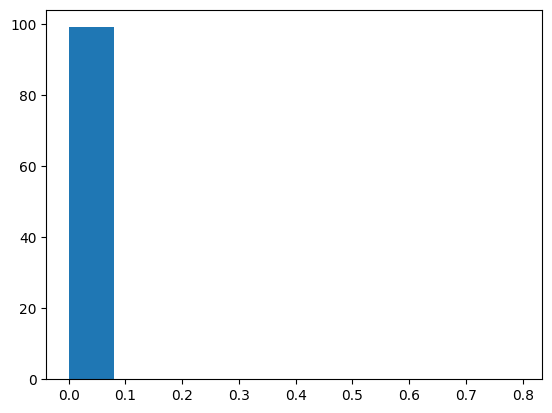

In [10]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
df = pd.read_parquet('processed_data/men_imbalanced_node_features.parquet')
# Define the ball criteria
ball_criteria = (df['dist_ball'] == 0) & (df['angle_ball'] == 0)
df['player_num_label'] = None

# Remap game_id to have no gaps
unique_game_ids = df['game_id'].unique()
game_id_mapping = {old_id: new_id for new_id, old_id in enumerate(sorted(unique_game_ids))}
df['game_id'] = df['game_id'].map(game_id_mapping)

# Impute label 0 for the ball
df.loc[ball_criteria, 'player_num_label'] = 0

# Iterate over each game_id with a progress bar
for game_id in tqdm(df['game_id'].unique(), desc="Processing Game IDs"):
    # Select the first frame (frame_id = 0) for the current game_id
    first_frame = df[(df['game_id'] == game_id) & (df['frame_id'] == 0) & (~ball_criteria)].copy()
    
    # Label the first 22 non-ball players
    first_frame['player_num_label'] = np.arange(1, 23)
    
    # Update the main dataframe with these labels
    df.update(first_frame[['player_num_label']])
    
    # Set prev_frame_data for tracking players across frames
    prev_frame_data = first_frame

    # Iterate through subsequent frames for the current game_id with a progress bar
    frame_ids = sorted(df[df['game_id'] == game_id]['frame_id'].unique())
    for frame_id in tqdm(frame_ids, desc=f"Processing Frames for Game ID {game_id}", leave=False):
        if frame_id == 0:
            continue
        
        # Get current frame data excluding the ball
        current_frame_data = df[(df['game_id'] == game_id) & (df['frame_id'] == frame_id) & (~ball_criteria)].copy()

        if current_frame_data.empty:
            continue

        # Compute Euclidean distance from each player in the current frame to each player in the previous frame
        distance_matrix = np.sqrt(
            (current_frame_data['x'].values[:, np.newaxis] - prev_frame_data['x'].values) ** 2 +
            (current_frame_data['y'].values[:, np.newaxis] - prev_frame_data['y'].values) ** 2
        )

        labeled_indices = []
        # Iterate through each player in the previous frame
        for i, prev_row in prev_frame_data.iterrows():
            if len(current_frame_data) == 0:
                break

            # Filter the current frame data to only include rows with the same att_team value
            team_filtered_data = current_frame_data[current_frame_data['att_team'] == prev_row['att_team']]

            if team_filtered_data.empty:
                continue

            # Calculate the Euclidean distance to the filtered current frame data
            distances = np.sqrt(
                (team_filtered_data['x'].values - prev_row['x']) ** 2 +
                (team_filtered_data['y'].values - prev_row['y']) ** 2
            )

            # Find the closest point in the filtered current frame
            if len(distances) == 0:
                continue

            closest_idx = np.argmin(distances)
            
            # Ensure the index is valid
            if closest_idx >= len(team_filtered_data):
                continue

            closest_point_idx = team_filtered_data.index[closest_idx]

            # Assign the label from the previous frame
            df.loc[closest_point_idx, 'player_num_label'] = prev_row['player_num_label']

            # Remove the labeled point from current_frame_data
            current_frame_data = current_frame_data.drop(index=closest_point_idx)

        # Update prev_frame_data for the next iteration
        prev_frame_data = df[(df['game_id'] == game_id) & (df['frame_id'] == frame_id) & (~ball_criteria)]

# Ensure the labels are integers
df['player_num_label'] = df['player_num_label'].astype(int)

# Check the difference between the current and previous x and y coordinates for each player
df_test = df[~ball_criteria].copy()
df_test = df_test.sort_values(['game_id', 'frame_id', 'player_num_label'])
df_test['x_prev'] = df_test.groupby(['game_id', 'player_num_label'])['x'].shift(1)
df_test['y_prev'] = df_test.groupby(['game_id', 'player_num_label'])['y'].shift(1)
df_test['euclidean_dist'] = np.sqrt((df_test['x'] - df_test['x_prev'])**2 + (df_test['y'] - df_test['y_prev'])**2)

# Plot the distribution of Euclidean distances as a percentage
weights = np.ones(len(df_test)) / len(df_test) * 100
n, bins, patches = plt.hist(df_test['euclidean_dist'], bins=10, weights=weights)

# Calculate raw counts for each bin
counts, _ = np.histogram(df_test['euclidean_dist'], bins=bins)

# Create a DataFrame for the bin statistics
bin_ranges = [f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(bins) - 1)]
percentages = [f"{n[i]:.1f}%" for i in range(len(n))]
raw_counts = counts

# Construct the DataFrame
df_bins = pd.DataFrame({
    'Bin Range': bin_ranges,
    'Percentage': percentages,
    'Count': raw_counts
})

# Display only bins with non-zero percentages
df_bins_non_zero = df_bins[df_bins['Count'] > 0]
print(df_bins_non_zero)
output_path = "./processed_data/men_imbalanced_node_features_numbered.parquet"

df.to_parquet(output_path, index=False, engine='pyarrow')